In [1]:
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [3]:
#import splitfolders
#splitfolders.ratio('F:/softcom/dataset/festivals-Splitted/train', output="F:/softcom/dataset/festivals-Splitted/output", seed=1337, ratio=(.85, 0.15)) 

In [4]:
# import pandas as pd

# train_dir = "F:/softcom/dataset/festivals-Splitted - Copy/train"
# img_height,img_width=224,224
# batch_size=100
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   train_dir,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# dataset_unbatched = tuple(train_ds.unbatch())
# labels = []
# for (image,label) in dataset_unbatched:
#     labels.append(label.numpy())
# labels = pd.Series(labels)

# # adjustments
# count = labels.value_counts().sort_index()
# count.index = train_ds.class_names

# print(count)

In [5]:
train_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/train"
test_dir = "F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/festivals dataset/festivals-Splitted/test"

# Image size and batch size
img_height,img_width = 224, 224
img_size = (img_height,img_width)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3175 files belonging to 24 classes.
Using 2540 files for training.
Found 3175 files belonging to 24 classes.
Using 635 files for validation.
Found 804 files belonging to 24 classes.


In [6]:
class_weights_manual = {
    0: 19.3/71,
    1: 19.3/117,
    2: 19.3/90,
    3: 19.3/73,
    4: 19.3/63,
    5: 19.3/251,
    6: 19.3/272,
    7: 19.3/131,
    8: 19.3/204,
    9: 19.3/121,
    10: 19.3/193,
    11: 19.3/112,
    12: 19.3/71,
    13: 19.3/64,
    14: 19.3/98,
    15: 19.3/98,
    16: 19.3/90,
    17: 19.3/39,
    18: 19.3/50,
    19: 19.3/107,
    20: 19.3/62,
    21: 19.3/127,
    22: 19.3/64,
    23: 19.3/119
}

In [7]:
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3), dtype=tf.uint8))
model.add(tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32)))
model.add(tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input))

pretrained_model= tf.keras.applications.MobileNet(include_top=False,
                   input_shape=(img_height,img_width,3),
                   weights='imagenet')
for layer in pretrained_model.layers[:int(len(pretrained_model.layers)*.75)]:   
       layer.trainable=False

model.add(pretrained_model)
# Add GlobalAveragePooling layer
model.add(GlobalAveragePooling2D())
# [:int(len(pretrained_model.layers)*.75)]
# Add fully connected layer with L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(24, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.summary()

17225924/17225924 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 module_wrapper (ModuleWrapp  (None, 1024)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              524800    
 pper)                                                   

In [8]:
checkpoint_filepath = 'F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/mobilenetckpt.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=20, min_lr=0.00001)

In [9]:
# optimizers = [
#     tf.keras.optimizers.Adam(learning_rate=1e-5),
#     tf.keras.optimizers.Adam(learning_rate=1e-3)
# ]
# optimizers_and_layers = [(optimizers[0:3], model.layers[0]), (optimizers[1], model.layers[3:])]
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              sample_weight_mode='temporal'
             )
epochs=300

In [10]:
from datetime import datetime
start = datetime.now()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose="auto",
  callbacks=[model_checkpoint_callback,lr_callback],
  epochs=epochs, #class_weight=class_weights_manual
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
159/159 [==============================] - 27s 114ms/step - loss: 2.1125 - accuracy: 0.4087 - val_loss: 3.0844 - val_accuracy: 0.3055 - lr: 0.0010
Epoch 2/300
159/159 [==============================] - 8s 47ms/step - loss: 1.2864 - accuracy: 0.6413 - val_loss: 2.6344 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 3/300
159/159 [==============================] - 8s 46ms/step - loss: 0.9225 - accuracy: 0.7287 - val_loss: 3.3786 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 4/300
159/159 [==============================] - 8s 46ms/step - loss: 0.6459 - accuracy: 0.8201 - val_loss: 2.6984 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 5/300
159/159 [==============================] - 8s 47ms/step - loss: 0.5251 - accuracy: 0.8476 - val_loss: 2.1444 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 6/300
159/159 [==============================] - 8s 46ms/step - loss: 0.4130 - accuracy: 0.8748 - val_loss: 2.0733 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 7/300
159/159 [==============================] - 8

Epoch 53/300
159/159 [==============================] - 8s 46ms/step - loss: 0.1360 - accuracy: 0.9673 - val_loss: 2.9192 - val_accuracy: 0.5906 - lr: 0.0010
Epoch 54/300
159/159 [==============================] - 8s 47ms/step - loss: 0.1009 - accuracy: 0.9787 - val_loss: 1.9784 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 55/300
159/159 [==============================] - 8s 46ms/step - loss: 0.0362 - accuracy: 0.9902 - val_loss: 2.3789 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 56/300
159/159 [==============================] - 8s 46ms/step - loss: 0.0434 - accuracy: 0.9882 - val_loss: 2.1168 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 57/300
159/159 [==============================] - 8s 47ms/step - loss: 0.0535 - accuracy: 0.9862 - val_loss: 2.0433 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 58/300
159/159 [==============================] - 8s 47ms/step - loss: 0.0356 - accuracy: 0.9894 - val_loss: 1.9700 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 59/300
159/159 [==============================

Epoch 154/300
159/159 [==============================] - 8s 46ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 2.8504 - val_accuracy: 0.7276 - lr: 1.2500e-04
Epoch 155/300
159/159 [==============================] - 8s 47ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 2.8496 - val_accuracy: 0.7181 - lr: 1.2500e-04
Epoch 156/300
159/159 [==============================] - 8s 50ms/step - loss: 3.6501e-05 - accuracy: 1.0000 - val_loss: 2.8185 - val_accuracy: 0.7228 - lr: 1.2500e-04
Epoch 157/300
159/159 [==============================] - 8s 48ms/step - loss: 4.7380e-04 - accuracy: 0.9996 - val_loss: 2.7985 - val_accuracy: 0.7276 - lr: 1.2500e-04
Epoch 158/300
159/159 [==============================] - 8s 48ms/step - loss: 1.6008e-04 - accuracy: 1.0000 - val_loss: 2.8456 - val_accuracy: 0.7244 - lr: 1.2500e-04
Epoch 159/300
159/159 [==============================] - 8s 47ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 2.9077 - val_accuracy: 0.7276 - lr: 1.2500e-04
Epoch 160/

159/159 [==============================] - 8s 48ms/step - loss: 3.0328e-06 - accuracy: 1.0000 - val_loss: 2.9233 - val_accuracy: 0.7339 - lr: 1.0000e-05
Epoch 253/300
159/159 [==============================] - 8s 48ms/step - loss: 2.2016e-04 - accuracy: 1.0000 - val_loss: 2.9213 - val_accuracy: 0.7339 - lr: 1.0000e-05
Epoch 254/300
159/159 [==============================] - 8s 47ms/step - loss: 6.1336e-06 - accuracy: 1.0000 - val_loss: 2.9235 - val_accuracy: 0.7339 - lr: 1.0000e-05
Epoch 255/300
159/159 [==============================] - 8s 48ms/step - loss: 4.1773e-06 - accuracy: 1.0000 - val_loss: 2.9222 - val_accuracy: 0.7339 - lr: 1.0000e-05
Epoch 256/300
159/159 [==============================] - 8s 47ms/step - loss: 3.7780e-04 - accuracy: 0.9996 - val_loss: 2.9312 - val_accuracy: 0.7323 - lr: 1.0000e-05
Epoch 257/300
159/159 [==============================] - 8s 48ms/step - loss: 1.1249e-04 - accuracy: 1.0000 - val_loss: 2.9139 - val_accuracy: 0.7323 - lr: 1.0000e-05
Epoch 258/30

In [11]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["accuracy", "val accuracy"], loc="upper left")
    plt.show()

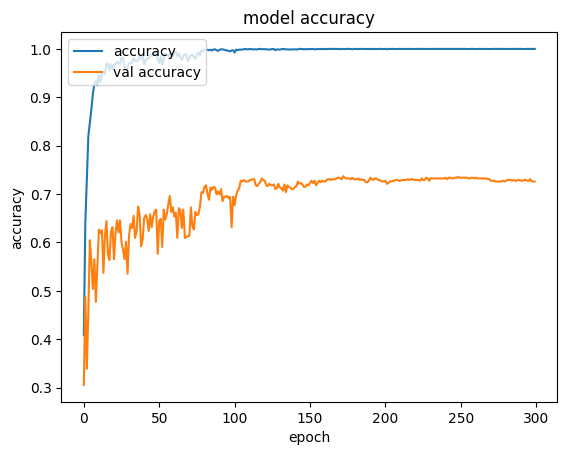

In [12]:
plot_hist(history)

In [13]:
result=model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose="auto"
)
#7463

51/51 [==============================] - 2s 26ms/step - loss: 2.6684 - accuracy: 0.7488


In [14]:
#save

# model.save_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/mobilenet.h5', overwrite=True, save_format=None, options=None)

#load

#model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/mobilenetckpt.h5', skip_mismatch=False, by_name=False, options=None)

#model.load_weights('F:/AUST/4.2/8. CSE4238 - Soft Computing Lab/Project/Project Last Run/mobilenet.h5', skip_mismatch=False, by_name=False, options=None)


1/1 [==============================] - 0s 18ms/step


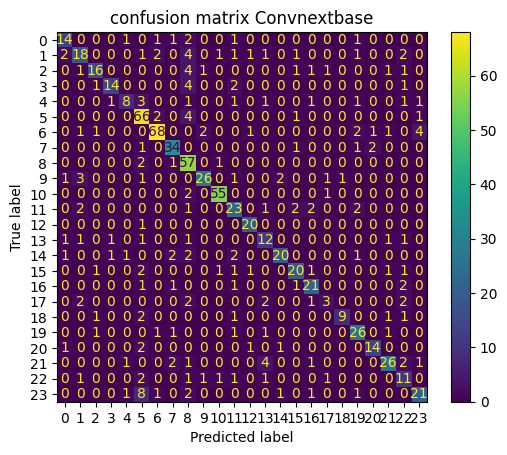

accuracy:  74.87562189054727
precision: [0.7        0.62068966 0.76190476 0.82352941 0.66666667 0.70967742
 0.90666667 0.80952381 0.64772727 0.86666667 0.93220339 0.63888889
 0.83333333 0.52173913 0.83333333 0.74074074 0.72413793 0.42857143
 0.9        0.72222222 0.82352941 0.8125     0.44       0.75      ]
recall: [0.66666667 0.51428571 0.59259259 0.63636364 0.42105263 0.89189189
 0.83950617 0.87179487 0.93442623 0.72222222 0.94827586 0.6969697
 0.95238095 0.63157895 0.66666667 0.68965517 0.77777778 0.25
 0.6        0.8125     0.73684211 0.68421053 0.55       0.58333333]
fscore: [0.68292683 0.5625     0.66666667 0.71794872 0.51612903 0.79041916
 0.87179487 0.83950617 0.76510067 0.78787879 0.94017094 0.66666667
 0.88888889 0.57142857 0.74074074 0.71428571 0.75       0.31578947
 0.72       0.76470588 0.77777778 0.74285714 0.48888889 0.65625   ]
support: [21 35 27 22 19 74 81 39 61 36 58 33 21 19 30 29 27 12 15 32 19 38 20 36]


In [15]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("confusion matrix Convnextbase")
plt.show()
precision, recall, fscore, support = score(y_true, y_pred)

print("accuracy: ",100*accuracy_score(y_true, y_pred))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))